## Figure X. Model error

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import zipfile
import pandas as pd
from tqdm.auto import tqdm
from io import TextIOWrapper
from collections import defaultdict

In [98]:
def get_records(path, measure):

    trial_indices = defaultdict(int)
    with zipfile.ZipFile(path, 'r') as z:
        for filename in tqdm(z.namelist()):
            if filename.endswith('.json'):
                with z.open(filename) as file:
                    with TextIOWrapper(file, encoding='utf-8') as text_file:
                        try:
                            result = json.load(text_file)
                            record = pd.DataFrame(
                                result['annotations']
                            ).reindex(
                                columns=['ABL1 pIC50', 'Log P', 'Log S', 'Step Made', 'Step Scored']
                            )

                            value = float(filename.split('_')[-2]) # result[measure]
                            trial_indices[value] += 1
                            record[measure] = value
                            record['trial'] = trial_indices[value]
                            
                            records.append(record)
                            result = None
                        except:
                            continue
    return records

paths = [
    '../../dgym-data/analysis/noise/selection_noise_2024-05-10_23-36-56_continued.zip',
]

measure = 'sigma'
records = []
for path in paths:
    records.extend(get_records(path, measure))

df_raw = pd.concat(records)
records = None

  0%|          | 0/500 [00:00<?, ?it/s]

In [99]:
from dgym.envs.utility import MultipleUtilityFunction, ClassicUtilityFunction

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    ideal=(9, 13),
    acceptable=(8, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(-0.5, 3.5),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-4, 1),
    acceptable=(-4, 1)
)

composite_utility_function = MultipleUtilityFunction(
    utility_functions = [docking_utility_function, log_P_utility_function, log_S_utility_function],
    weights = [0.8, 0.1, 0.1]
)

In [100]:
records = []
for (value, trial), data in tqdm(df_raw.groupby([measure, 'trial'])):
    utility = composite_utility_function(data.values, precompute=True, method='average')
    try:
        completion_idx = utility.index(1.0)
        success = 1
    except:
        completion_idx = len(utility)
        success = 0
    
    # find number made and scored
    data_to_completion = data.iloc[:completion_idx+1]
    num_made = len(data_to_completion.dropna(subset='Step Made'))
    num_scored = len(data_to_completion.dropna(subset='Step Scored'))
    
    record = {
        measure: value,
        'trial': trial,
        'outcome': success,
        'number_scored': num_scored,
        'number_made': num_made,
        'time': data['Step Made'].max()
    }
    records.append(record)

df = pd.DataFrame(records)

  0%|          | 0/500 [00:00<?, ?it/s]

Plotting adjusted outcomes.

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Determine the maximum cost to extend the eCDF
def get_ecdf(budget_type):
    
    max_cost = df[budget_type].max()
    timeline = np.linspace(0, max_cost, 500)

    ecdfs = []
    for idx, (value, group) \
        in enumerate(df.groupby(measure)):

        # Create Kaplan-Meier object
        kmf = KaplanMeierFitter()

        # Fit data
        kmf.fit(
            durations=group[budget_type],
            event_observed=group['outcome'],
            timeline=timeline,
            alpha=0.32
        )

        # add confidence intervals
        ecdf_ = pd.merge(
            kmf.cumulative_density_,
            right=kmf.confidence_interval_cumulative_density_,
            left_index=True,
            right_index=True
        ).reset_index()

        ecdf_[measure] = value
        ecdfs.append(ecdf_)

    ecdf = pd.concat(ecdfs)
    
    return ecdf

budget = 'number_made'
ecdf = get_ecdf(budget)

<>:26: DeprecationWarning: invalid escape sequence '\s'
<>:32: DeprecationWarning: invalid escape sequence '\s'
<>:26: DeprecationWarning: invalid escape sequence '\s'
<>:32: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_5495/877340108.py:26: DeprecationWarning: invalid escape sequence '\s'
  plt.legend(title='$\sigma$')
/tmp/ipykernel_5495/877340108.py:32: DeprecationWarning: invalid escape sequence '\s'
  plt.title('Cumulative probability of success versus model error ($\sigma$)')
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.

Text(0.5, 1.0, 'Cumulative probability of success versus model error ($\\sigma$)')

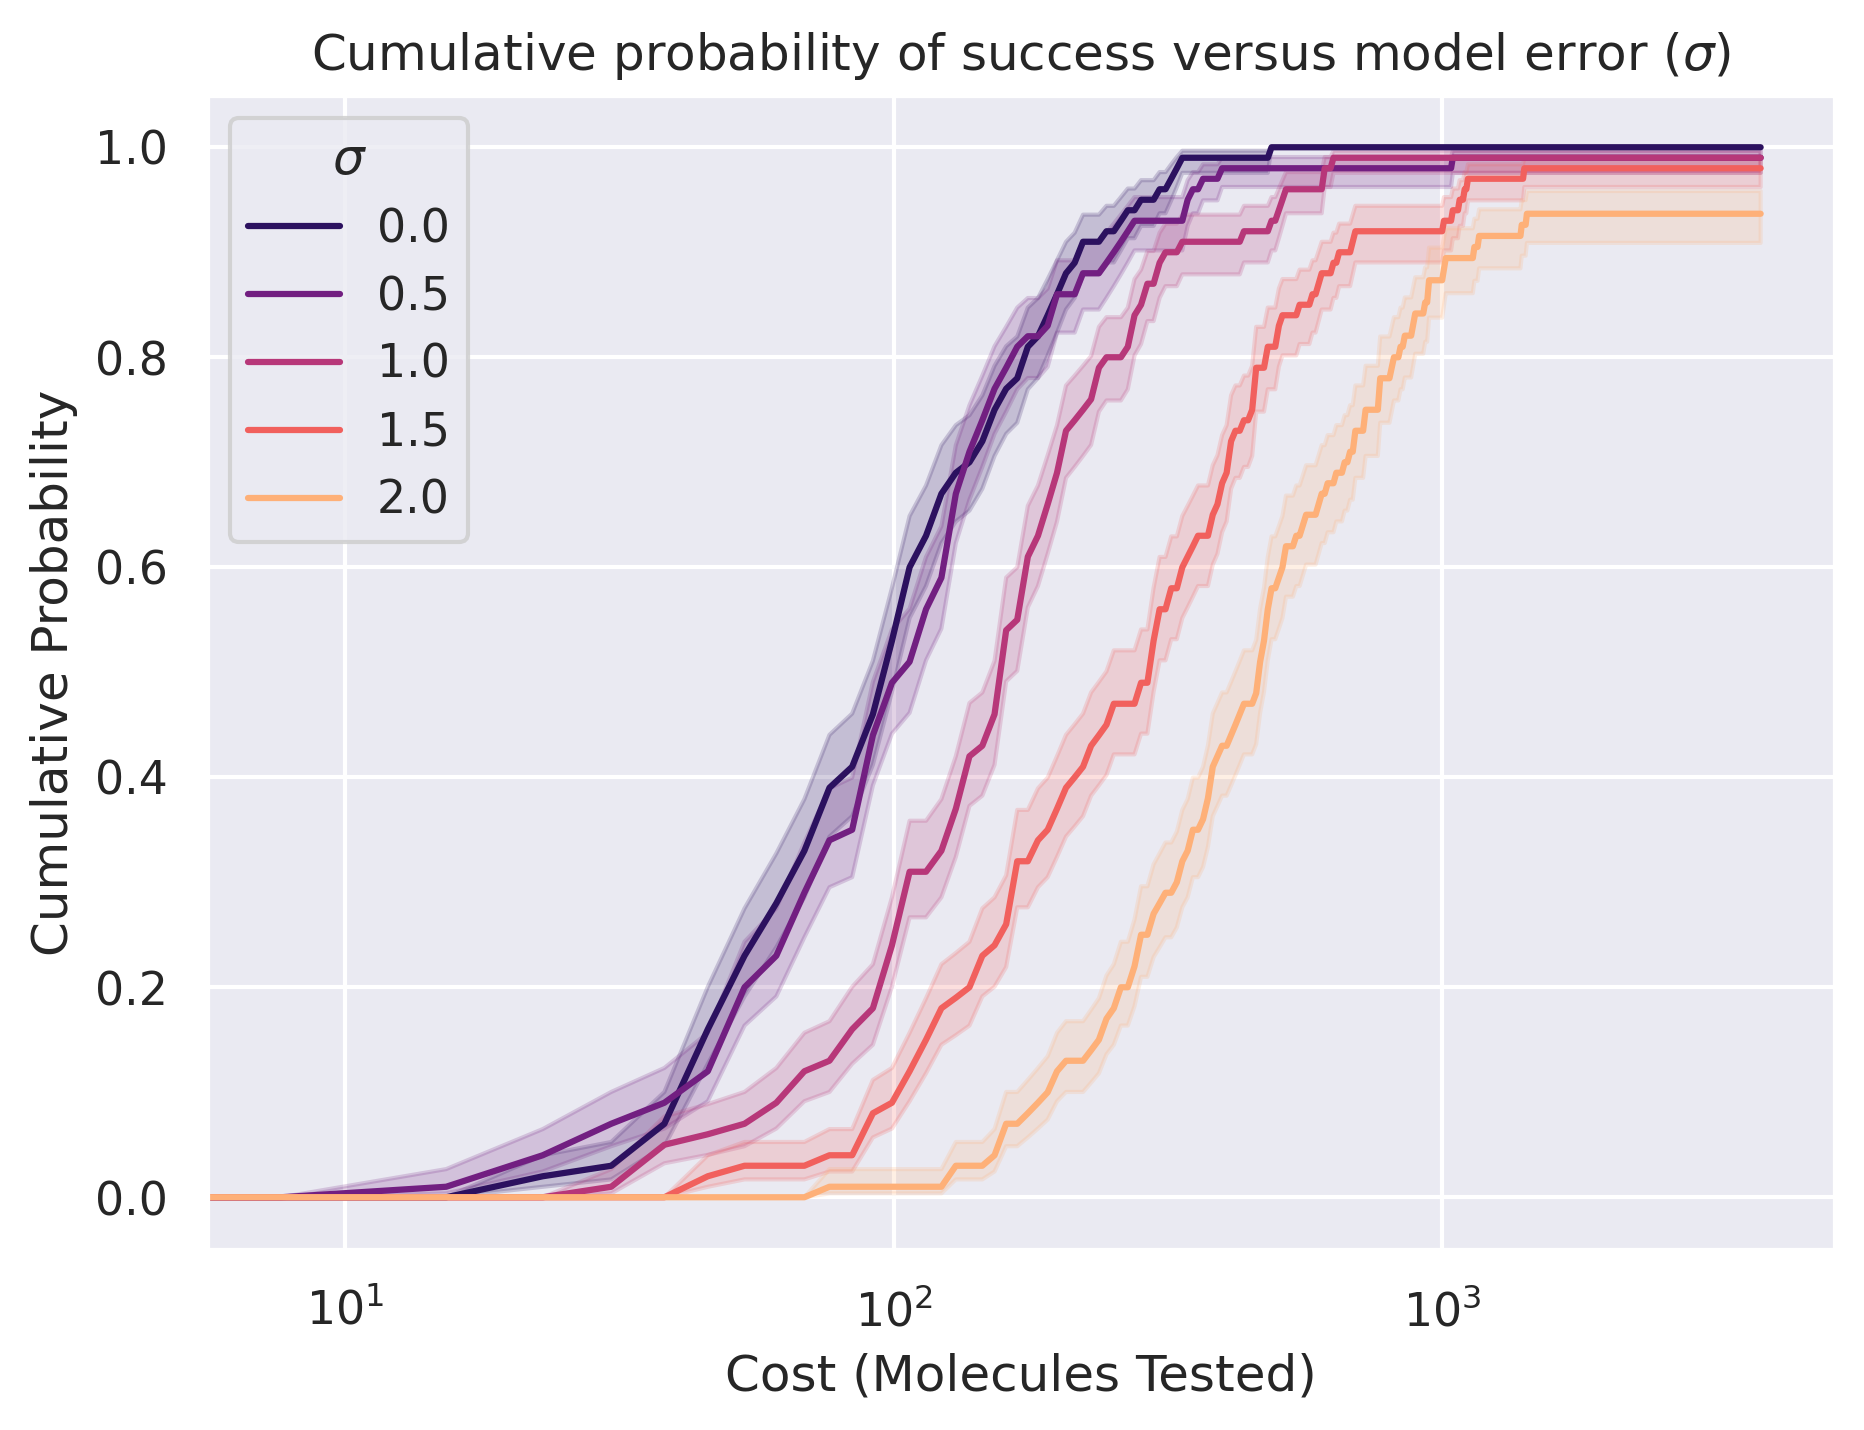

In [104]:
import seaborn as sns

plt.figure(figsize=(7, 5), dpi=300)

sns.set()
colors = sns.color_palette(
    'magma', len(ecdf['sigma'].unique()))

g = sns.lineplot(
    ecdf,
    x='timeline',
    y='KM_estimate',
    hue=measure,
    palette=colors
)

for idx, (name, group) in enumerate(ecdf.groupby(measure)):
    g.fill_between(
        group['timeline'],
        group['KM_estimate_lower_0.68'],
        group['KM_estimate_upper_0.68'],
        alpha=0.2,
        color=colors[idx]
    )

plt.legend(title='$\sigma$')
plt.xlabel('Cost (Molecules Tested)')
plt.ylabel('Cumulative Probability')
# plt.xlim(-0.05, 2000)
plt.xscale('log')
# plt.ylim(-0.05, 1.05)
plt.title('Cumulative probability of success versus model error ($\sigma$)')

### Plot variable vs. outcome

<>:33: DeprecationWarning: invalid escape sequence '\s'
<>:33: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_5495/3184938736.py:33: DeprecationWarning: invalid escape sequence '\s'
  plt.xlabel('Model error ($\sigma$)')
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

Text(0.5, 1.0, 'Success rate versus model error under fixed budgets')

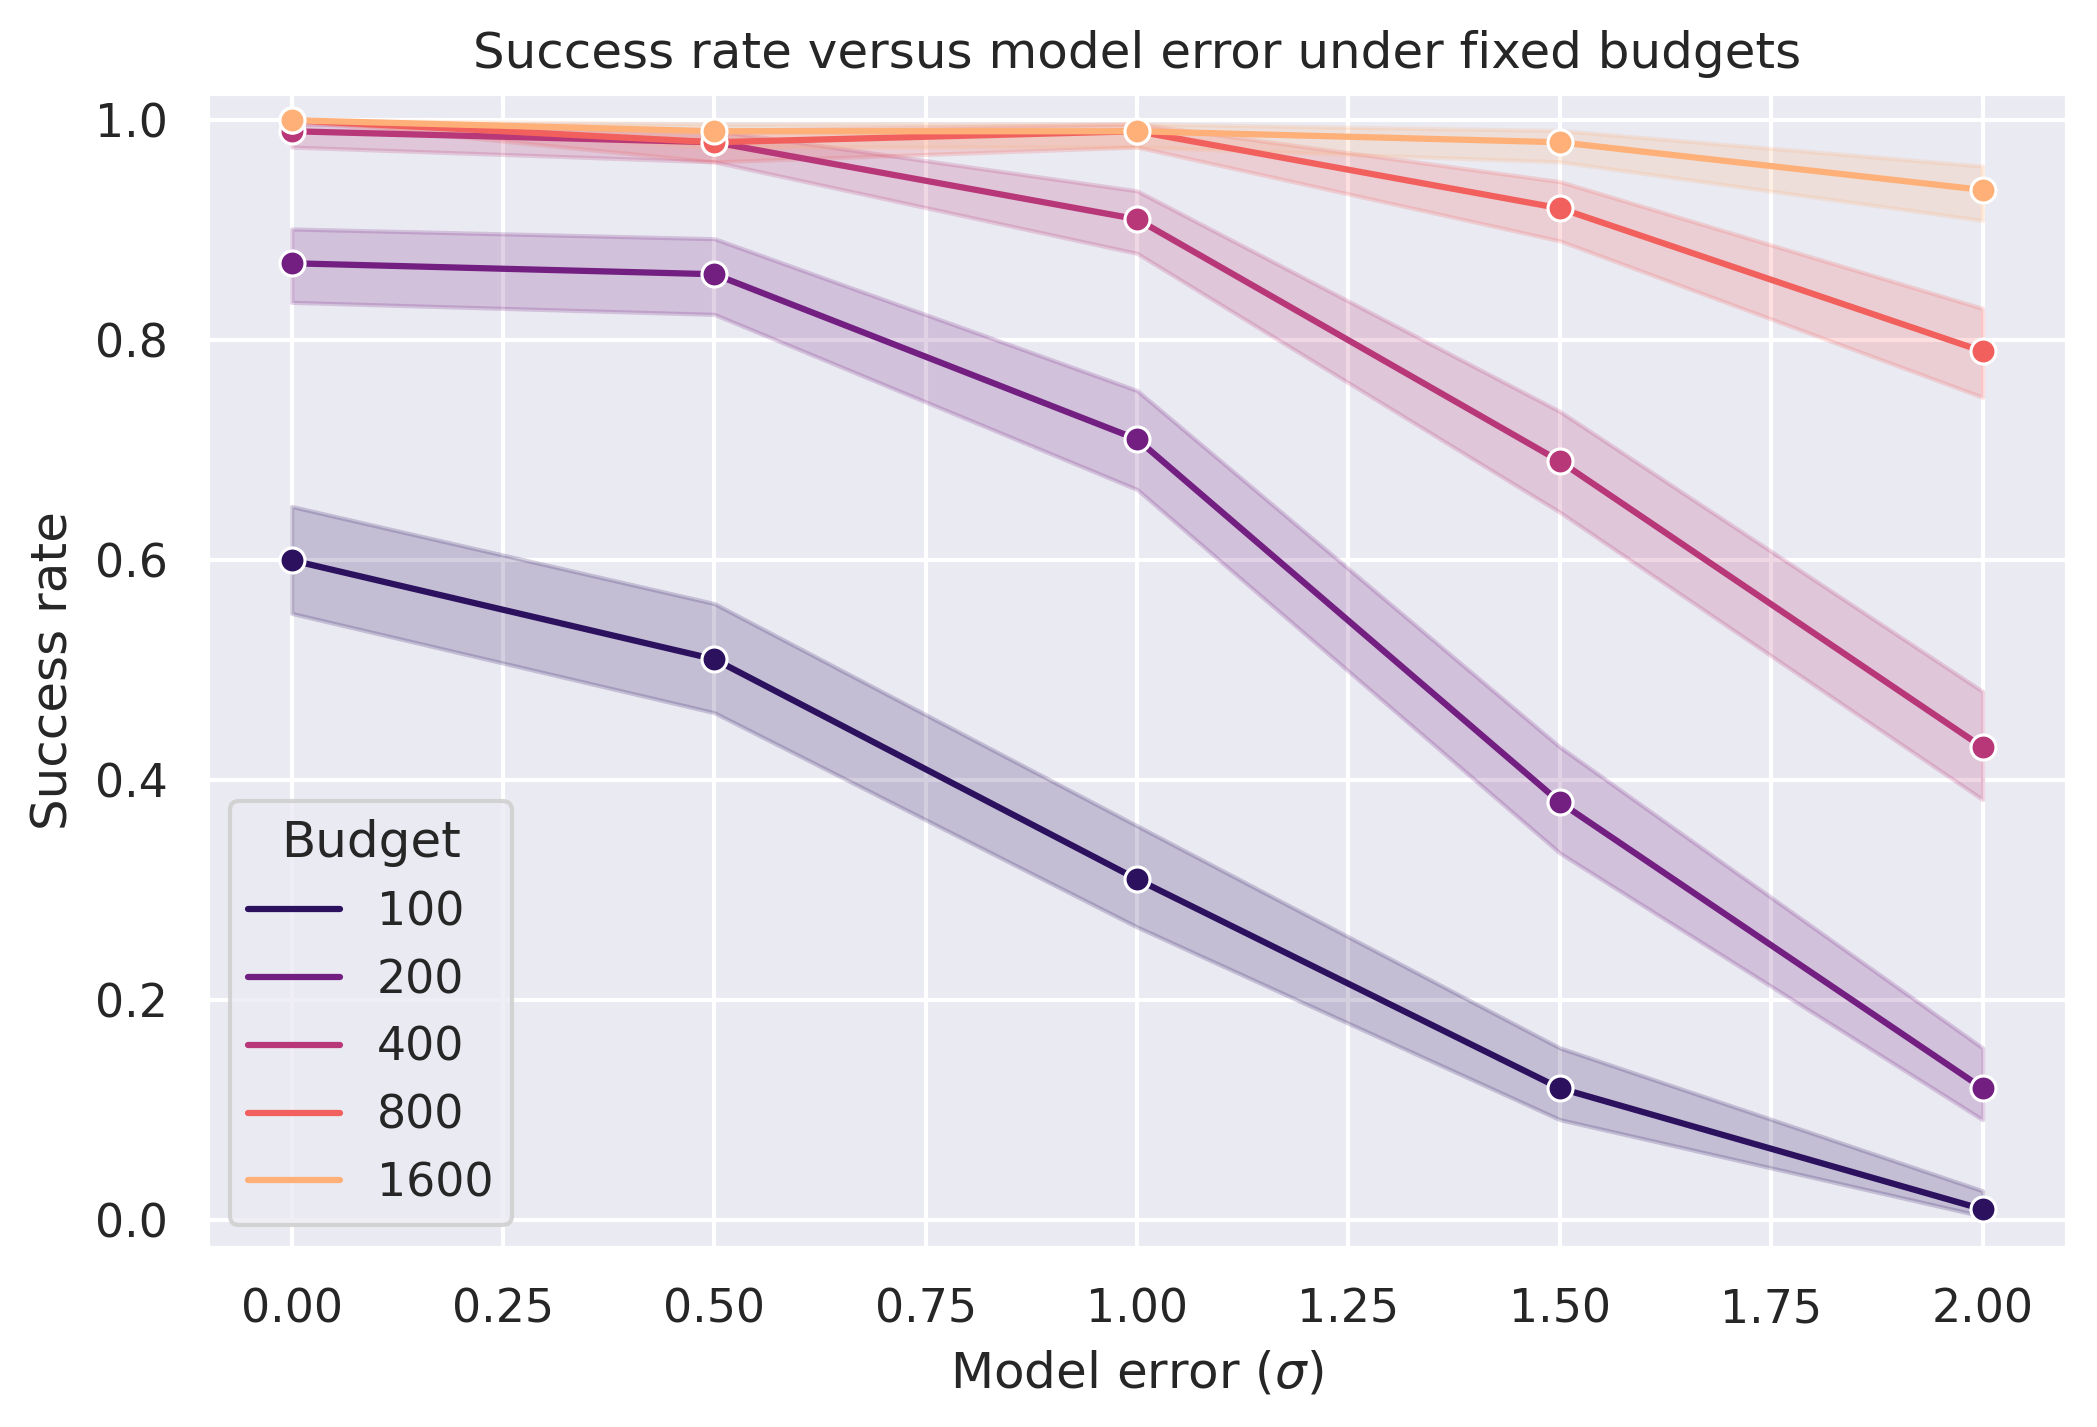

In [7]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

budget_sigma = []
for budget in [100, 200, 400, 800, 1600]:
    filtered = ecdf.query(
        f'{budget} < timeline < {budget} + 5').copy()
    filtered['Budget'] = budget
    budget_sigma.append(filtered)
budget_sigma = pd.concat(budget_sigma)

g = sns.lineplot(
    budget_sigma,
    x='sigma',
    y='KM_estimate',
    hue='Budget',
    marker='o',
    ci=False,
    palette=sns.color_palette('magma', len(budget_sigma['Budget'].unique())),
    ax=ax
)

colors = sns.color_palette('magma', len(budget_sigma['Budget'].unique()))
for idx, (name, group) in enumerate(budget_sigma.groupby('Budget')):
    g.fill_between(
        group['sigma'],
        group['KM_estimate_lower_0.68'],
        group['KM_estimate_upper_0.68'],
        alpha=0.2,
        color=colors[idx],
    )

plt.ylim(-0.025, 1.025)
plt.xlabel('Model error ($\sigma$)')
plt.ylabel(f'Success rate')
plt.title(f'Success rate versus model error under fixed budgets')

## Expectation costs to achieve probability of success

In [67]:
def closest_success_rate(df, target_success_rates, success_rate_var, measure_var):
    """
    Filters the DataFrame to get the budgets that are closest to the target budgets within each setting of 'variable'.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least two columns: 'budget' and 'variable'.
    target_budgets : list of float
        List of target budgets to compare against.
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the rows with budgets closest to the target budgets within each setting of 'variable'.
    """
    def find_and_replace(df_group, targets):
        closest_rows = []
        for target in targets:
            # Filter for success rates that are at least the target success rate
            filtered_df = df_group # [df_group[success_rate_var] >= target]
            if not filtered_df.empty:
                # Find the closest budget less than or equal to the target budget
                closest_row = filtered_df.loc[(filtered_df[success_rate_var] - target).abs().idxmin()]
                closest_row['Success Rate'] = target
                closest_rows.append(closest_row)
        return pd.DataFrame(closest_rows)

    return df.groupby(measure_var).apply(find_and_replace, targets=target_success_rates).reset_index(drop=True)

<>:40: DeprecationWarning: invalid escape sequence '\s'
<>:40: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_5495/3683464559.py:40: DeprecationWarning: invalid escape sequence '\s'
  plt.xlabel('Model error ($\sigma$)')
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

Text(0.5, 1.0, 'Expected cost versus model error')

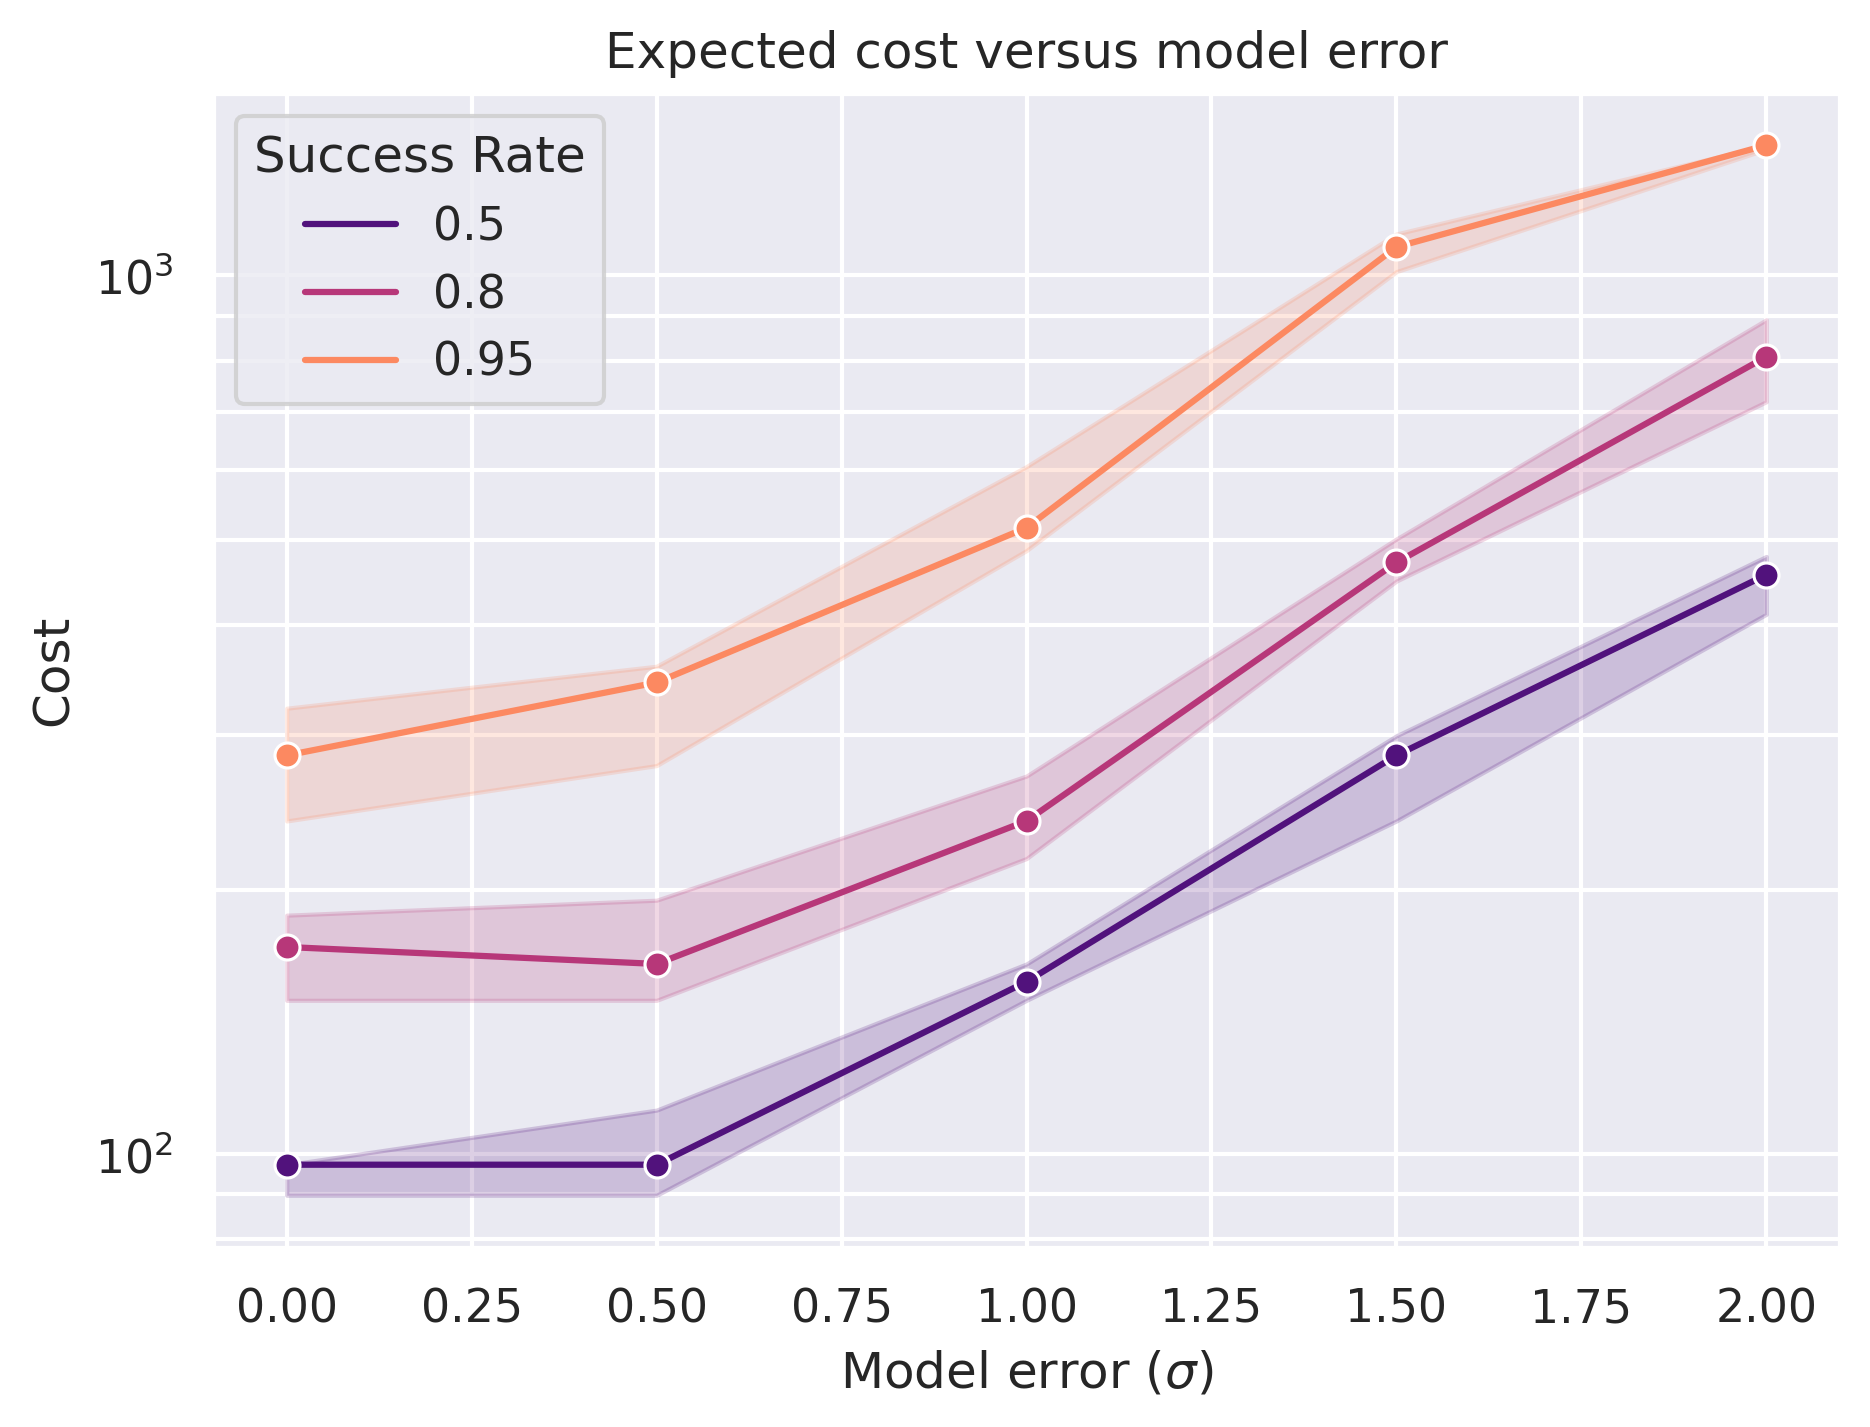

In [88]:
import matplotlib.ticker as ticker
plt.figure(figsize=(7, 5), dpi=300)

success_rates = [0.5, 0.8, 0.95] # np.linspace(0, 0.8, 2001)
prob = closest_success_rate(ecdf, success_rates, 'KM_estimate', measure)
prob_low = closest_success_rate(ecdf, success_rates, 'KM_estimate_lower_0.68', measure)
prob_high = closest_success_rate(ecdf, success_rates, 'KM_estimate_upper_0.68', measure)

g = sns.lineplot(
    prob,
    x=measure,
    y='timeline',
    marker='o',
    hue='Success Rate',
    ci=False,
    palette=sns.color_palette('magma', len(prob['Success Rate'].unique())),
)

colors = sns.color_palette('magma', len(prob['Success Rate'].unique()))
for idx, success_rate in enumerate(success_rates):
    g.fill_between(
        prob.query(f'`Success Rate` == {success_rate}')[measure],
        prob_low.query(f'`Success Rate` == {success_rate}')['timeline'],
        prob_high.query(f'`Success Rate` == {success_rate}')['timeline'],
        alpha=0.2,
        color=colors[idx]
    )

# iterate through each axes
g.grid(True, which="both", axis='y')
locmin = ticker.LogLocator(
    base=10,
    subs=np.arange(0.1,1,0.1),
    numticks=10
)
g.yaxis.set_minor_locator(locmin)
g.set_yscale('log')

plt.ylim(0)
plt.xlabel('Model error ($\sigma$)')
plt.ylabel(f'Cost')
plt.title(f'Expected cost versus model error')

# Exponential regression

Expected cost of each sigma as a function of probability of success.

In [97]:
summary = (
    prob
    .groupby(['sigma', 'timeline'])
    .agg('mean').reset_index()
    .reindex(columns=['sigma', 'timeline', 'Success Rate'])
    .rename(columns={'sigma': 'Sigma', 'timeline': 'Budget'})
)

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential function with two variables
def exp_func(X, a, b, c, d):
    Sigma, Success_Rate = X
    return a * np.exp(b * Sigma + c * Success_Rate) + d

# Extracting inputs and output
sigma = prob.reset_index()['sigma'].values
success_rate = prob['Success Rate'].values
budget = prob['timeline'].values

# Combine the inputs into a single matrix
X = np.vstack((sigma, success_rate))

# Fit the model
initial_guess = [1, 1, 1, 1]  # Initial guess for the parameters
params, covariance = curve_fit(exp_func, X, budget, p0=initial_guess)

# Predict using the model
budget_pred = exp_func(X, *params)

print("Fitted parameters:", params)

Fitted parameters: [16.90781536  1.07339091  2.11939697 16.5772379 ]


<>:18: DeprecationWarning: invalid escape sequence '\s'
<>:18: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_5495/469236402.py:18: DeprecationWarning: invalid escape sequence '\s'
  ax.set_xlabel('Model error ($\sigma$)')
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

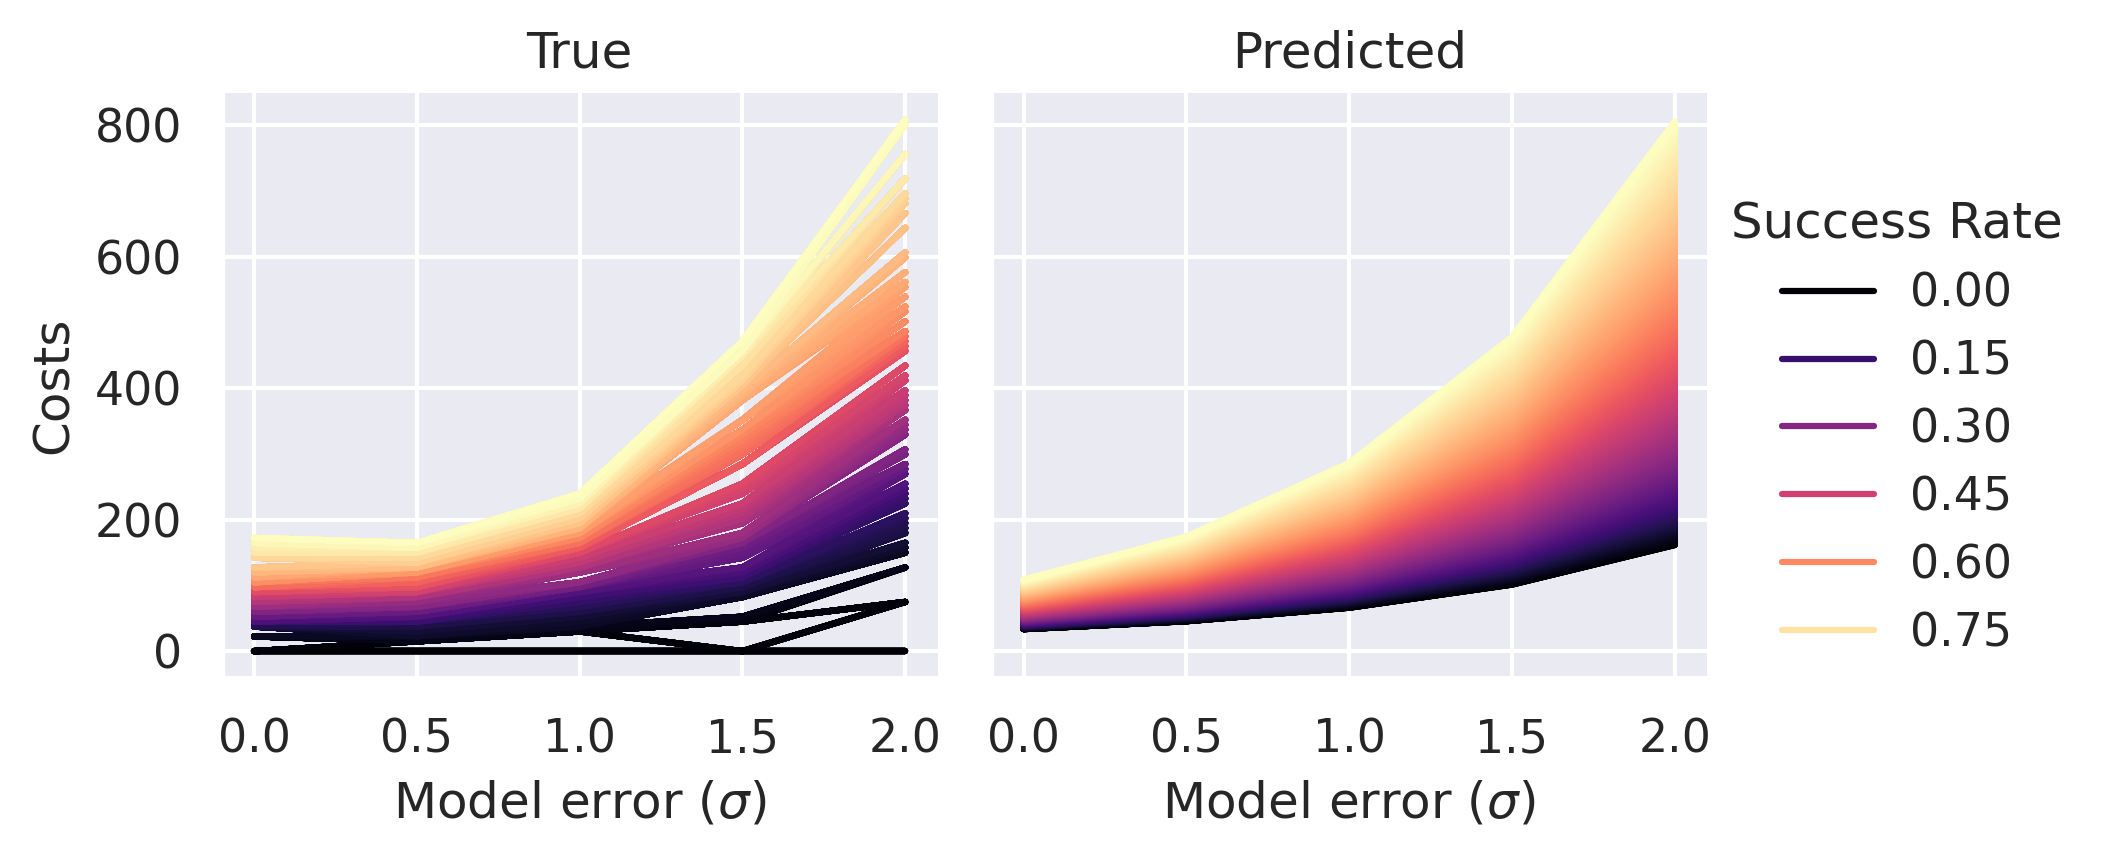

In [87]:
model = pd.DataFrame({
    'budget': budget,
    'budget_pred': budget_pred,
    'sigma': sigma,
    'success_rate': success_rate
})

model_long = model.melt(id_vars=['success_rate', 'sigma'])
g = sns.FacetGrid(model_long, col='variable', sharey=True)
g.map(sns.lineplot, 'sigma', 'value', 'success_rate', palette='magma')
g.fig.set_dpi(300)
g.add_legend(title='Success Rate')
axes = g.axes.flatten()
axes[0].set_title('True')
axes[1].set_title('Predicted')
axes[0].set_ylabel('Costs')
for ax in axes:
    ax.set_xlabel('Model error ($\sigma$)')

# Computing expected savings

In [522]:
# Function to perform bootstrap sampling within each group
def bootstrap_sample(group):
    return group.sample(n=len(group), replace=True)

bootstraps = []
for idx in tqdm(range(10_000)):

    # Apply the bootstrap sampling within each group
    bootstrapped_df = df.groupby('trial', group_keys=False).apply(bootstrap_sample)

    # Compute median for scored and made molecules
    medians = (
        bootstrapped_df
        .groupby('sigma')
        .agg({'number_scored': 'median', 'number_made': 'median'})
        .reset_index()
    ).copy()
    
    # Compute relevant statistics
    medians['total_cost'] = medians['number_made'] * 100
    expected_cost = medians.query('sigma == 2.0')['total_cost'].item()
    medians['savings'] = expected_cost - medians['total_cost']
    medians['Breakeven ($)'] = medians['savings'] / medians['number_scored']

    # Append
    medians['bootstrap'] = idx
    bootstraps.append(medians)

bootstraps_raw = pd.concat(bootstraps)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [594]:
# Function to compute the confidence interval
def lower_bound(data, confidence_level=0.95):
    lower_percentile = (1 - confidence_level) / 2
    lower_bound = np.percentile(data, lower_percentile * 100)
    return lower_bound

def upper_bound(data, confidence_level=0.95):
    upper_percentile = 1 - (1 - confidence_level) / 2
    upper_bound = np.percentile(data, upper_percentile * 100)
    return upper_bound

bootstraps = (
    bootstraps_raw
    .groupby('sigma', as_index=False)
    .agg({
        'Breakeven ($)': ['mean', lower_bound, upper_bound],
    })
)

bootstraps.columns = list(map(''.join, bootstraps.columns.values))

<>:26: DeprecationWarning: invalid escape sequence '\s'
<>:27: DeprecationWarning: invalid escape sequence '\s'
<>:26: DeprecationWarning: invalid escape sequence '\s'
<>:27: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_5495/348391786.py:26: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel("Marginal value beyond $\sigma=2$ (\$)")
/tmp/ipykernel_5495/348391786.py:27: DeprecationWarning: invalid escape sequence '\s'
  plt.xlabel('Model error ($\sigma$)')
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype)

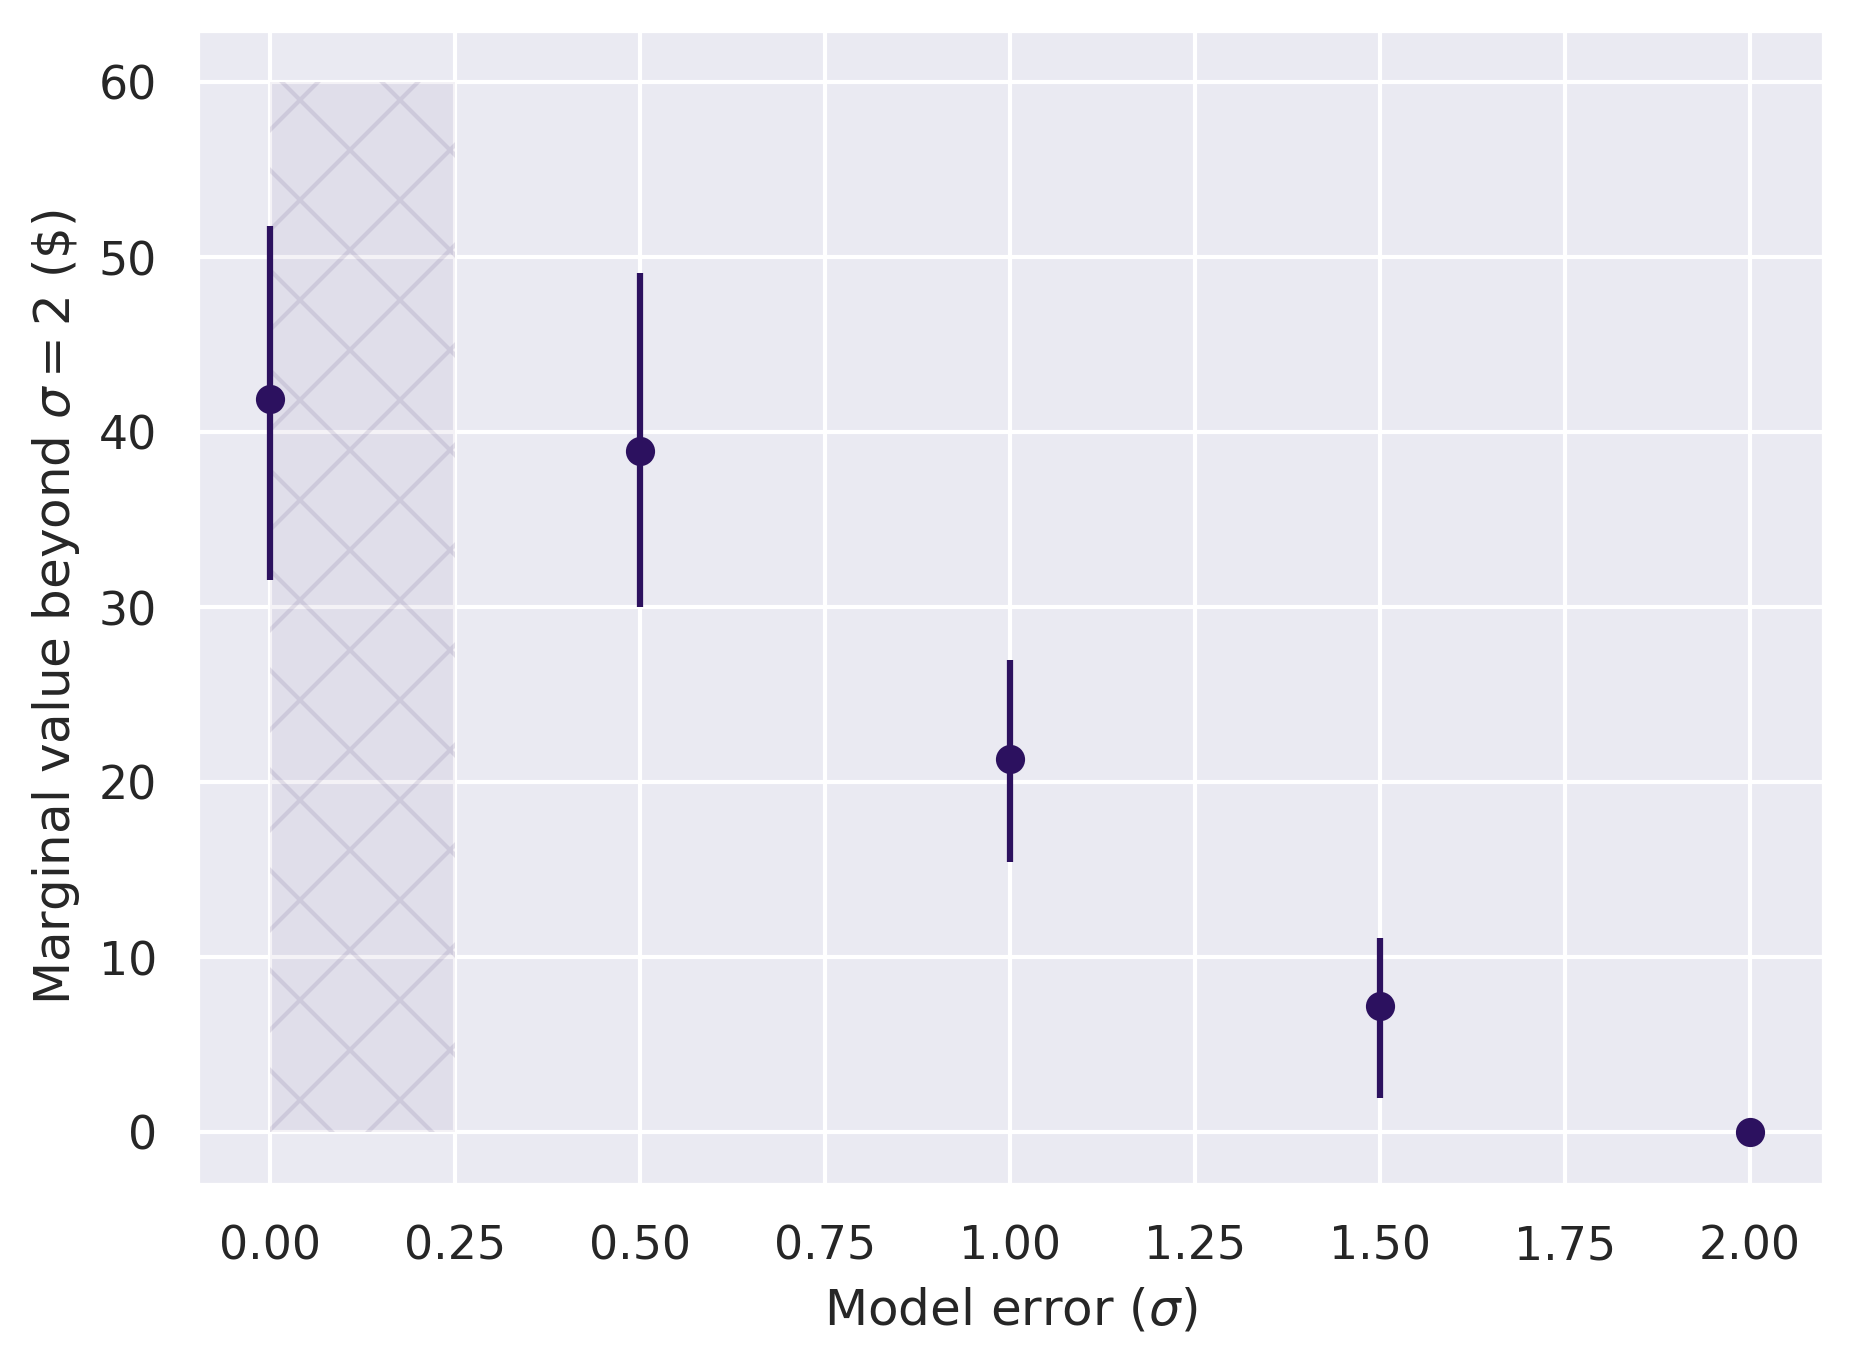

In [657]:
plt.figure(figsize=(7, 5), dpi=300)
g = sns.scatterplot(
    bootstraps,
    x='sigma',
    y='Breakeven ($)mean',
    marker='o',
    c='#2C115F'
)

plt.errorbar(
    x=bootstraps['sigma'],
    y=bootstraps['Breakeven ($)mean'],
    yerr=[
        abs(bootstraps['Breakeven ($)mean']
         - bootstraps['Breakeven ($)upper_bound']),
        abs(bootstraps['Breakeven ($)mean']
         - bootstraps['Breakeven ($)lower_bound']),
    ],
    fmt='o',
    capsize=5,
    capthick=0,
    elinewidth=1.5,
    c='#2C115F'
)

plt.ylabel("Marginal value beyond $\sigma=2$ (\$)")
plt.xlabel('Model error ($\sigma$)')
plt.fill_between(
    [0, 0.25],
    [0, 60],
    step='pre',
    alpha=0.05,
    facecolor='#2C115F',
    linewidth=0.0
)
plt.fill_between(
    [0, 0.25],
    [0, 60],
    step='pre',
    facecolor='none',
    hatch='X',
    edgecolor='#2C115F',
    alpha=0.1,
    linewidth=0.0
)

# plt.fill_between([0, 0.25], [0,60], step='pre', alpha=0.1, facecolor='red', linewidth=0.0)
# plt.fill_between([0, 0.25], [0,60], step='pre', facecolor='none', hatch='X', edgecolor='white', alpha=0.5, linewidth=0.0)